# Extended SEIRS Community TTI Demo

**In this demonstration we will explore the effect of testing, tracing, and isolation interventions on disease transmission in the setting of an age-stratified population with a realistic contact network structured by households and work/school communities.**

This notebook provides a demonstration of the functionality of the [Extended SEIRS Network Model](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description) and the [TTI Simulation Loop](https://github.com/ryansmcgee/seirsplus/wiki/TTI-Simulation-Loop). This notebook also offers a sandbox for starting to explore TTI scenarios of your own. 
For a more thorough walkthrough of the model, simulation loop, and use of this package, refer to the [SEIRS+ Wiki](https://github.com/ryansmcgee/seirsplus/wiki).

### Installing and importing the model code

All of the code needed to run the model is imported from the ```models``` module of this package.

In this demo we will also use features from the `networks`, `sim_loops`, and `utilities` modules.

#### Install the package using ```pip```
The package can be installed on your machine by entering this in the command line:

```pip install seirsplus```

Then, the ```models```, `networks`, `sim_loops`, and `utilities` modules can be imported as shown here:

In [1]:
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
import networkx
import matplotlib.pyplot as pyplot

#### *Alternatively, manually copy the code to your machine*
*You can use the model code without installing a package by copying the ```models.py``` module file to a directory on your machine. For some of the features used in this demo you will also need the `networks`, `sim_loops`, and `utilities` modules. In this case, the easiest way to use the modules is to place your scripts in the same directory as the modules, and import the modules as shown here:*
```python
from models import *
from networks import *
from sim_loops import *
from utilities import *
```

-------

## Set basic parameters

Set the total population size

Here we set the initial prevalence to be 1% of the population.

Set the max simulation time to 100 days.

In [2]:
T = 100
INIT_EXPOSED_PCT = 20/330

-------

## Specifying contact networks

I'm doing it myself in this one

In [3]:
from epi_model import *

In [4]:
tnet = temporalNetwork.load('high school2')

In [5]:
w = tnet.to_weighted()

In [6]:
nodes = sorted(w.nodes)
n2id = {n:i for i,n in enumerate(w.node_ids)}

In [7]:
G = nx.Graph()

In [8]:
weights = np.array([c for i,j,c in w.edgelist])

In [9]:
atom = np.min(weights[weights>0])

In [10]:
G.add_weighted_edges_from( [(n2id[i], n2id[j], c / (10 * atom * 60*15 / 20)) for i,j,c in w.edgelist] )

In [11]:
#demographic_graphs, individual_ageGroups, households = generate_demographic_contact_network(
#                                                            N=N, demographic_data=household_country_data('US'), 
#                                                            distancing_scales=[0.7], isolation_groups=[])
                                      
G_baseline = G
G_quarantine = G_baseline.copy()

#households_indices = [household['indices'] for household in households]

Baseline:
Degree: mean = 96.94, std = 38.31, 95% CI = (10.00, 161.00)
        coeff var = 0.40
Assortativity:    0.13
Clustering coeff: 0.27



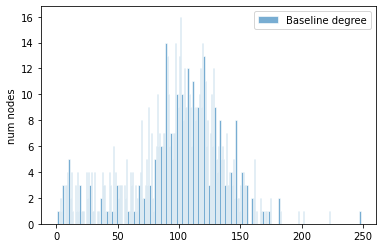

In [12]:
network_info(G_baseline, "Baseline", plot=True)

Quarantine:
Degree: mean = 96.94, std = 38.31, 95% CI = (10.00, 161.00)
        coeff var = 0.40
Assortativity:    0.13
Clustering coeff: 0.27



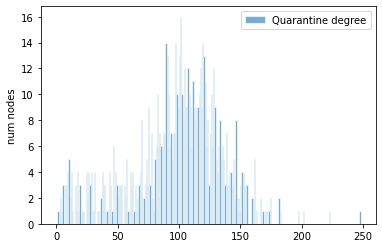

In [13]:
network_info(G_quarantine, "Quarantine", plot=True)

In [14]:
N = len(G.nodes)
INIT_EXPOSED = int(N*INIT_EXPOSED_PCT)

-------

## Specifying parameters

**_The parameter values used in this notebook reflect rough estimates of parameter values for the COVID-19 epidemic (as of 9 Aug 2020)._**

### Set disease progression rate parameters:

Parameter values are assigned to members of the population on an individual basis. Parameter values can be [specified to the `ExtSEIRSNetworkModel`](https://github.com/ryansmcgee/seirsplus/wiki/ExtSEIRSNetworkModel-Class#specifying-parameters) by providing a list of values that gives the *N* values to assign to each individual. The population may be either homogeneous or heterogeneous for a given parameter at the user's discretion. 

**Here we generate distributions of values for each parameter, and some parameter value are specified in an age-stratified manner, thus specifying a realistically heterogeneous population.**

Generate a distribution of expected latent periods (time in Exposed state) and presymptomatic periods (time in Pre-symptomatic infectious state). The `sigma` and `lamda` rates are calculated as the inverse of the expected exposed and pre-symptomatic periods assigned to each individual, respectively.

latent period:  mean = 2.20, std = 1.07, 95% CI = (0.60, 4.94)

pre-symptomatic period:  mean = 2.92, std = 1.83, 95% CI = (0.57, 7.52)

total incubation period:  mean = 5.12, std = 2.16, 95% CI = (1.85, 10.24)



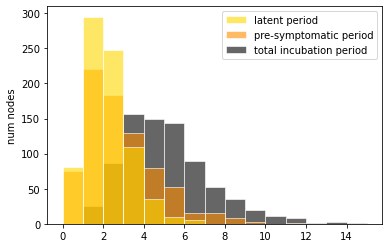

In [15]:
latentPeriod_mean, latentPeriod_coeffvar = 3.0, 0.6
SIGMA   = 1 / gamma_dist(latentPeriod_mean, latentPeriod_coeffvar, N)

presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar = 2.2, 0.5
LAMDA   = 1 / gamma_dist(presymptomaticPeriod_mean, presymptomaticPeriod_coeffvar, N)

dist_info([1/LAMDA, 1/SIGMA, 1/LAMDA+1/SIGMA], ["latent period", "pre-symptomatic period", "total incubation period"], plot=True, colors=['gold', 'darkorange', 'black'], reverse_plot=True)

Generate a distribution of expected (a)symptomatic periods (time in symptomatic or asymptomatic state). The `gamma` rates are calculated as the inverse of the expected (a)symptomatic periods assigned to each individual. 

The expected total infectious period for each individual is the sum of their expected pre-symptomatic and (a)symptomatic periods.

pre-symptomatic period:  mean = 2.20, std = 1.07, 95% CI = (0.60, 4.94)

(a)symptomatic period:  mean = 3.92, std = 1.60, 95% CI = (1.39, 7.69)

total infectious period:  mean = 6.13, std = 1.91, 95% CI = (3.07, 10.31)



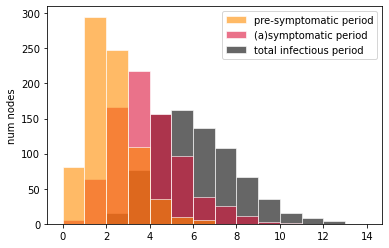

In [16]:
symptomaticPeriod_mean, symptomaticPeriod_coeffvar = 4.0, 0.4
GAMMA   = 1 / gamma_dist(symptomaticPeriod_mean, symptomaticPeriod_coeffvar, N)

infectiousPeriod = 1/LAMDA + 1/GAMMA

dist_info([1/LAMDA, 1/GAMMA, 1/LAMDA+1/GAMMA], ["pre-symptomatic period", "(a)symptomatic period", "total infectious period"], plot=True, colors=['darkorange', 'crimson', 'black'], reverse_plot=True)

Generate a distribution of expected onset-to-hospitalization periods (time in symptomatic state before entering hospitalized state for those with severe cases) and hospitalization-to-discharge periods (time in hospitalized state for those with non-fatal cases). The `eta` and `gamma_H` rates are calculated as the inverse of the expected onset-to-hospitalization periods and hospitalization-to-discharge periods assigned to each individual, respectively.

onset-to-hospitalization period:  mean = 11.64, std = 5.20, 95% CI = (4.00, 24.53)

hospitalization-to-discharge period:  mean = 10.84, std = 4.88, 95% CI = (3.28, 20.87)

onset-to-discharge period:  mean = 22.48, std = 7.10, 95% CI = (10.64, 39.78)



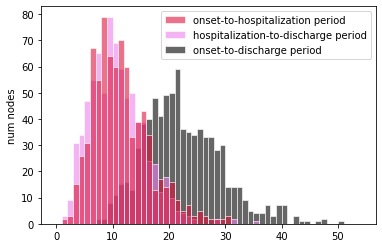

In [17]:
onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar = 11.0, 0.45
ETA     = 1 / gamma_dist(onsetToHospitalizationPeriod_mean, onsetToHospitalizationPeriod_coeffvar, N)

hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar = 11.0, 0.45
GAMMA_H = 1 / gamma_dist(hospitalizationToDischargePeriod_mean, hospitalizationToDischargePeriod_coeffvar, N)

dist_info([1/ETA, 1/GAMMA_H, 1/ETA+1/GAMMA_H], ["onset-to-hospitalization period", "hospitalization-to-discharge period", "onset-to-discharge period"], plot=True, colors=['crimson', 'violet', 'black'], reverse_plot=True)

Generate a distribution of hospitalization-to-death periods (time in hospitalized state for those with fatal cases). The `mu_H` rates are calculated as the inverse of the expected hospitalization-to-death periods.

onset-to-hospitalization period:  mean = 11.64, std = 5.20, 95% CI = (4.00, 24.53)

hospitalization-to-death period:  mean = 7.12, std = 3.16, 95% CI = (2.26, 14.37)

onset-to-death period:  mean = 18.76, std = 6.18, 95% CI = (9.28, 33.03)



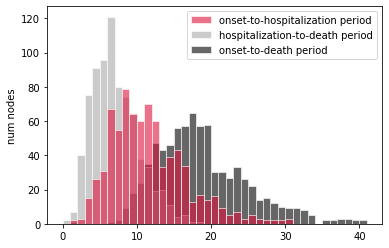

In [18]:
hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar = 7.0, 0.45
MU_H    = 1 / gamma_dist(hospitalizationToDeathPeriod_mean, hospitalizationToDeathPeriod_coeffvar, N)

dist_info([1/ETA, 1/MU_H, 1/ETA+1/MU_H], ["onset-to-hospitalization period", "hospitalization-to-death period", "onset-to-death period"], plot=True, colors=['crimson', 'darkgray', 'black'], reverse_plot=True)

### Set severity parameters

Specify the percentage of cases that are asymptomatic. This percentage of case will progress from the pre-symptomatic state to the asymptomatic state, rather than to the symptomatic state.

In [19]:
PCT_ASYMPTOMATIC = 0.8

Here we age-stratify our definition of asymptomatic rate by setting the percent of asymptomatic cases for children to be 80% while the rest of the adult population remains set at 25%.

The `individual_ageGroups` variable is returned by the [`generate_demographic_contact_network()` function](https://github.com/ryansmcgee/seirsplus/wiki/Network-generation#demographic-community-network) and holds a list of the age group labels assigned to each individual. This is useful for assigning parameters in an age-group-dependent way as we do for the following severity parameters.

In [20]:
PCT_HOSPITALIZED = 0.0004

Here we specify fatality rates for hospitalized cases, again using rates taken from [Verity et al. (2020)](https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext).

In [21]:
PCT_FATALITY = 0.3627

### Set transmission parameters

The [Extended SEIRS Network Model](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#stochastic-network-model-implementation) model considers two modes of disease transmission: a well-mixed mode of [global transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#global-transmission) and a contact network based mode of [local transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#local-transmission). The propensity for a given individual to become exposed due to global transmission depends on the mean transmissibility of all infectious individuals in the population; the propensity for a given individual to become exposed due to local transmission depends on the pairwise transmissibilities between the focal node and its infectious contacts in the network (see [Transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#transmission) and [Model Equations](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#model-equations) for more information about these calculations). 

The transmissibility parameter *β* can be related to the basic reproduction number *R<sub>0</sub>* (i.e., the expected number of new infections generated by a single infectious individual in a completely susceptible population) by the standard formula: *β = R<sub>0</sub>𝛾*. *R<sub>0</sub>* is a more interpretable parameter, so we specify transmissibility in terms of *R<sub>0</sub>* and then calculate the corresponding *β* values.

First, we generate a distribution of individual *R<sub>0</sub>* values (i.e., the expected number of new infections generated by a single *particular* infectious individual in a completely susceptible population). Of course, this means that transmissibility is heterogeneous in this population. The coefficient of variation is an important parameter for the individual *R<sub>0</sub>* distribution in that it tunes the degree of superspreading in the heterogeneous transmissibility. The distribution used in this example has a relatively low coefficient of variation, so most individuals have around the same degree of transmissibility. But a higher coefficient of variation (e.g., 2.0) would give a long right tail in idividual transmissibility representing a small number of individuals contributing many cases while the majority cases contribute less than 1 on average when they are infectious.

Individual R0:  mean = 2.51, std = 0.51, 95% CI = (1.67, 3.64)



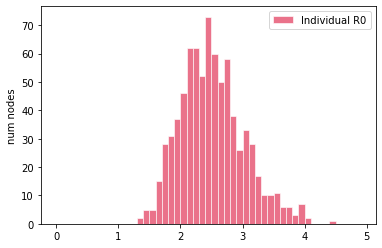

In [22]:
R0_mean     = 2.5
R0_coeffvar = 0.2

R0 = gamma_dist(R0_mean, R0_coeffvar, N)

dist_info(R0, "Individual R0", bin_size=0.1, plot=True, colors='crimson')

Individuals are ultimately assigned an [*Individual Transmissibility Value*](https://github.com/ryansmcgee/seirsplus/wiki/ExtSEIRSNetworkModel-Class#transmissibility-parameters) (*β<sup>i</sup>*), which are stored in the `beta` attribute of the model object. 

The means of the Individual Transmissibility Values for infectious subpopulations are used to calculate the [global transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#global-transmission) terms. Individual Transmissibility Values may also be used to generate the Pairwise Transmissibility Values used for [local transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#local-transmission) terms, as we will specify in a few steps.

In [23]:
BETA = 1/infectiousPeriod * R0

Individuals can be assigned different Individual Transmissibility Values for use when they are asymptomatic and quarantine states. 

Here we set the transmissibility of quarantined individuals such that the mean effective reproduction number for quarantined individuals is about 0.3. This supposes that individuals have different behavior, hygiene, etc. when they are quarantining relative to baseline.

In [24]:
BETA_Q = BETA * (0.3/R0_mean)

Now we specify how we would like the [*Pairwise Transmissibility Values*](https://github.com/ryansmcgee/seirsplus/wiki/ExtSEIRSNetworkModel-Class#transmissibility-parameters) (*β<sup>i</sup>*), which define the local transmissibility for each pair of close contacts, to be calculated. There are [multiple ways to specify these pairwise transmissibilities](https://github.com/ryansmcgee/seirsplus/wiki/ExtSEIRSNetworkModel-Class#pairwise-transmissibility-values) (such as providing a matrix), but here we will set the `beta_pairwise_mode` argument of the `ExtSEIRSNetworkModel` constructor to `'infected'`, which will direct the model to automatically generate a matrix of Pairwise Transmissibility Values such that the transmissibility of each infectious-susceptible interaction is equal to the infected individual's transmissiblity.

In [25]:
BETA_PAIRWISE_MODE  = 'infected'

Here we designate that we would like the model to automatically calculate [Connectivity Correction Factors](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#connectivity-correction-factor) for each pair of interacting close contacts. This pairwise factor is optional, but it can be used to weight the transmissibility of interactions according to the connectivity of the interacting individuals. Here we choose to weight interactions according to a ratio of the pair's mean degree to the population's mean degree (see [Specifying connectivity Correction Factors](https://github.com/ryansmcgee/seirsplus/wiki/ExtSEIRSNetworkModel-Class#connectivity-correction-factors) for more information). 

Using this definition, when two individuals whose average degree is an order of magnitude greater than the average degree of the population overall, then the propensity of exposure in their interaction is weighted to be twice that of two averagely-connected individuals. 

In [26]:
DELTA_PAIRWISE_MODE = 'mean'

Here we set individual susceptibilities (default susceptibility is 1). 

In particular, we specify that children are half as susceptible as adults.

In [27]:
ALPHA = 1
#ALPHA = 1.0

In the stochastic network model, an individual comes into contact with a random individual from the population at large (e.g., in a public space) with probability *p* or with an individual from their set of close contacts with probability *(1-p)*. Transmission that occurs between an individual and the population at large is referred to as [global transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#global-transmission), and transmission between an individual and one of their close contacts (network neighbors) is referred to as [local transmission](https://github.com/ryansmcgee/seirsplus/wiki/Extended-SEIRS-Model-Description#local-transmission). The parameter *p* defines the locality of the network: for *p=0* an individual only interacts with their close contacts, while *p=1* represents a uniformly mixed population.

Here we set *p* to reflect 20% of interactions being with incidental or casual contacts outside their set of close contacts.

In [28]:
P_GLOBALINTXN = 0

The parameter *q* (down)weights the rate of interactions with the population at large while one is in quarantine relative to baseline.

Here we set *q* to 0.05, which supposes that global interactions are quite rare (but nonzero) for quarantined individuals.

In [29]:
Q_GLOBALINTXN = 0

-------

## Initializing the model

In [30]:
Nn = len(G_baseline.nodes)
print(Nn)

784


In [31]:
model = ExtSEIRSNetworkModel(G=G_baseline, p=P_GLOBALINTXN,
                              beta=BETA, sigma=SIGMA, lamda=LAMDA, gamma=GAMMA, 
                              gamma_asym=GAMMA, eta=ETA, gamma_H=GAMMA_H, mu_H=MU_H, 
                              a=PCT_ASYMPTOMATIC, h=PCT_HOSPITALIZED, f=PCT_FATALITY,              
                              alpha=ALPHA, beta_pairwise_mode=BETA_PAIRWISE_MODE, delta_pairwise_mode=DELTA_PAIRWISE_MODE,
                              G_Q=G_quarantine, q=0, beta_Q=BETA_Q, isolation_time=14,
                              initE=INIT_EXPOSED)

-------

In [32]:
#ALPHA = [1 for _ in range(len(G_baseline.nodes))]
#ALPHA_SAVE = list(ALPHA)

# do a lot

In [33]:
weights = nx.get_edge_attributes(G_baseline,'weight')

In [34]:
wmat = np.zeros((Nn, Nn))
for i,(a,b) in enumerate(G_baseline.edges):
    wmat[a,b] = weights[(a,b)]

In [35]:
np.sum(wmat == 0)

576656

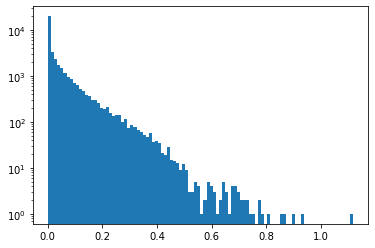

In [36]:
plt.hist((wmat[wmat>0]).flatten(), bins=100, log=True);

In [37]:
#atom = np.min(wmat[wmat>0])
#wmat_scaled = wmat / atom * 60*15 / 20
#plt.hist((wmat_scaled[wmat_scaled>0]).flatten(), bins=100, log=True);

In [38]:
INIT_EXPOSED = 30

In [39]:
model.numI_sym

array([0., 0., 0., ..., 0., 0., 0.])

In [40]:
base_args = {
    'G': G_baseline,
    'p': P_GLOBALINTXN,
    'beta': BETA,
    #'beta_local': wmat_scaled,
    'sigma': SIGMA,
    'lamda': LAMDA,
    'gamma': GAMMA,
    'gamma_asym': GAMMA,
    'eta':ETA,
    'gamma_H':GAMMA_H,
    'mu_H':MU_H,
    'a':PCT_ASYMPTOMATIC,
    'h':PCT_HOSPITALIZED,
    'f':PCT_FATALITY,
    'alpha':ALPHA,
    'beta_pairwise_mode':BETA_PAIRWISE_MODE,
    'delta_pairwise_mode':DELTA_PAIRWISE_MODE,
    'G_Q':G_quarantine,
    'q':Q_GLOBALINTXN,
    'beta_Q':BETA_Q,
    'isolation_time':14,
    'initI_asym':INIT_EXPOSED # note that I'm putting them into the asymptomatic infectious group, to be similar to the other...
}

In [41]:
from epi_model import *

In [42]:
nodes = sorted(G_baseline.nodes)
edges = list(G_baseline.edges)
net = unweightedNetwork(nodes, edges, 1)

In [43]:
p = dict(params.covid_estimate)
sim = simulations.SEIR_daily(net, p)

In [44]:
model = ExtSEIRSNetworkModel(G=G_baseline, p=P_GLOBALINTXN,
          beta=BETA, sigma=SIGMA, lamda=LAMDA, gamma=GAMMA) # a dummy for numks to resolve

In [45]:
attrs_to_keep = [k for k in model.__dict__ if 'num' == k[:3]]
attrs_to_keep += ['tseries']

In [46]:
def friendHighDegRandTop3(sim, vaccinateN):
    return sampling.friendHighDegRandTopN(sim, vaccinateN, N=3)
def friendHighDegRandTop5(sim, vaccinateN):
    return sampling.friendHighDegRandTopN(sim, vaccinateN, N=5)

In [47]:
strats = [
    sampling.friend,
    sampling.friendHighDeg,
    sampling.targeted,
    sampling.none,
    sampling.rand,
    #sampling.friendHighDegClose,
    #sampling.friendClose,
    sampling.friendHighDegChain,
    #sampling.friendWeightedChain,
    friendHighDegRandTop3,
    friendHighDegRandTop5,
]

In [48]:
models = defaultdict(list)

In [49]:
N_PER = 50

In [50]:
len(G_baseline.nodes)*0.1

78.4

In [51]:
from time import time

for strat in strats:    
    sname = strat.__name__
    print('Starting', sname)
    st = time()
    
    for i in range(N_PER - len(models[sname])):

        ns_to_remove = strat(sim, int(len(G_baseline.nodes)*0.1))
        
        ALPHA = [1 if i not in ns_to_remove else 0 for i in range(Nn)]
            
        args = dict(base_args)
        args['alpha'] = ALPHA
            
        model = ExtSEIRSNetworkModel(**args) 

        model.run(100,verbose=False)
        models[sname].append({
            k: getattr(model, k)
            for k in attrs_to_keep
        })
    print( f'{sname} finished after {time() - st:0.1f} seconds' )

Starting friend
friend finished after 14.0 seconds
Starting friendHighDeg
friendHighDeg finished after 13.4 seconds
Starting targeted
targeted finished after 13.6 seconds
Starting none
none finished after 14.5 seconds
Starting rand
rand finished after 14.4 seconds
Starting friendHighDegChain
friendHighDegChain finished after 14.6 seconds
Starting friendHighDegRandTop3
friendHighDegRandTop3 finished after 15.1 seconds
Starting friendHighDegRandTop5
friendHighDegRandTop5 finished after 15.1 seconds


In [52]:
xxx = model.A.todense()

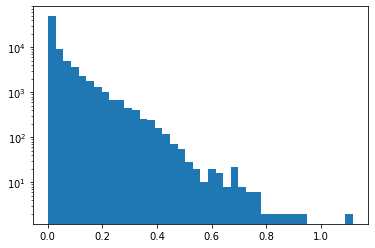

In [53]:
plt.hist(np.array(xxx[xxx>0]).flatten(), bins=40, log=True);

In [54]:
bool({})

False

In [55]:
[len(m) for m in models.values()]

[50, 50, 50, 50, 50, 50, 50, 50]

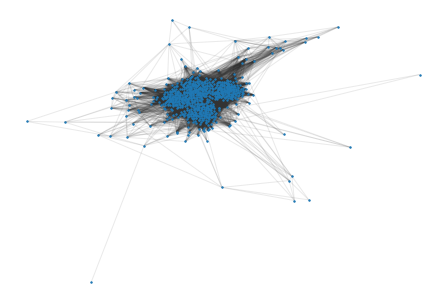

In [56]:
nx.draw(G, node_size=2, edge_color=(0.2,0.2,0.2,0.1))

In [57]:
model.numI_

AttributeError: 'ExtSEIRSNetworkModel' object has no attribute 'numI_'

In [ ]:
for k in models:
    for i in range(len(models[k])):
        m = models[k][i]

        plt.plot(m['tseries'], m['numI_asym'] + m['numI_pre'] + m['numI_sym'], label=i, linewidth=1, color='black', alpha=0.03)
    #plt.legend()
    plt.title(k)
    plt.ylim(0,m['numNodes'])
    plt.show()

In [ ]:
for k in models:
    for i in range(len(models[k])):
        m = models[k][i]

        plt.plot(m['tseries'], m['numNodes'] - m['numS'], label=i, linewidth=1, color='black', alpha=0.03)
    #plt.legend()
    plt.title(k)
    plt.ylim(0,m['numNodes'])
    plt.show()

In [ ]:
def get_N(m, t):
    latest = np.max( np.where( m['tseries'] <= t ) )
    return m['numNodes'] - m['numS'][latest]

In [ ]:
ts = np.arange(0,100, 0.2)
plt.plot(
    ts,
    [get_N(m, t) for t in ts]
)

In [ ]:
ts = np.arange(0,100, 0.2)
for k in models:
    series = [np.mean( [get_N(m, t) for m in models[k]] ) for t in ts]
    plt.plot( ts, series, label=k )
plt.legend();

In [ ]:
ts = np.arange(20,60, 1)

means = {}
for k in models:
    means[k] = np.mean( [ (m['numNodes'] - m['numS'])[-1] for m in models[k] ]  )
    
for k in sorted(models, key=lambda x:means[x]):
    series = [np.mean( [get_N(m, t) for m in models[k]] ) for t in ts]
    plt.plot( ts, series, label=k )
plt.legend();
plt.ylim(80,94)
plt.xlim(20,60)

In [ ]:
ts = np.arange(20,60, 1)

means = {}
for k in models:
    means[k] = np.mean( [ (m['numNodes'] - m['numS'])[-1] for m in models[k] ]  )
    
QUANTILE = 0.75
    
for k in sorted(models, key=lambda x:means[x]):
    series = [np.mean( [get_N(m, t) for m in models[k]] ) for t in ts]
    plt.plot( ts, series, label=k )
    
    smax = [np.quantile( [get_N(m, t) for m in models[k]], QUANTILE ) for t in ts]
    smin = [np.quantile( [get_N(m, t) for m in models[k]], 1-QUANTILE ) for t in ts]
    plt.plot(ts, smin)
    plt.plot(ts, smax)
    
plt.legend();
#plt.ylim(80,94)
#plt.xlim(20,60)

In [ ]:
ts = np.arange(20,60, 1)

means = {}
for k in models:
    means[k] = np.mean( [ (m['numNodes'] - m['numS'])[-1] for m in models[k] ]  )
    
for k in sorted(models, key=lambda x:means[x]):
    series = [np.max( [get_N(m, t) for m in models[k]] ) for t in ts]
    plt.plot( ts, series, label=k )
plt.legend();
#plt.ylim(80,94)
#plt.xlim(20,60)

In [ ]:
ks = sorted(models)

In [ ]:
means, stds = {}, {}
for k in ks:
    means[k] = np.mean( [ (m['numNodes'] - m['numS'])[-1] for m in models[k] ]  )
    stds[k] = np.std( [ (m['numNodes'] - m['numS'])[-1] for m in models[k] ]  )

In [ ]:
from scipy.stats import wilcoxon

In [ ]:
wilcoxons = {}

for k1 in ks:
    for k2 in ks:
        if k1 == k2:
            val = np.nan
        else:
            val = wilcoxon( 
                [ (m['numNodes'] - m['numS'])[-1] for m in models[k1] ],
                [ (m['numNodes'] - m['numS'])[-1] for m in models[k2] ] 
            ).pvalue
        wilcoxons[(k1,k2)] = val

In [ ]:
plt.hist( [x for x in wilcoxons.values()], bins=30 );

In [ ]:
wilcox_mat = np.zeros((len(ks),len(ks)))

In [ ]:
for (k1,k2), val in wilcoxons.items():
    wilcox_mat[ 
        ks.index(k1),
        ks.index(k2)
    ] = val

In [ ]:
plt.imshow(wilcox_mat)
plt.xticks(range(len(ks)),ks,rotation='vertical')
plt.yticks(range(len(ks)),ks);
plt.colorbar();

for ki1 in range(len(ks)):
    for ki2 in range(len(ks)):
        if wilcox_mat[ki1,ki2] < 0.05:
            plt.text( ki1-0.25, ki2+0.5, "*", color='white', size=30 )

In [ ]:
ks = sorted(models, key=lambda x:means[x])

In [ ]:
ks.remove('none')

In [ ]:
ks

In [ ]:
stds

In [ ]:
plt.errorbar?

In [ ]:
marr = np.array([means[k] for k in ks])
sarr = np.array([stds[k] for k in ks])
N = len(models['none'])

plt.bar(
    ks,
    marr
)
plt.errorbar(
    ks,
    marr,
    yerr=sarr/np.sqrt(N),
    color='black'
)
plt.ylim(605,620)
plt.xticks(ks, rotation='vertical');

In [ ]:
for k in models:
    m = np.mean( [ (m['numNodes'] - m['numS'])[-1] for m in models[k] ]  )
    print(f'{k}: {m:0.1f}')